# EEG Analysis

In this notebook, we will analyze an EEG dataset, the [MIPDB dataset](http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/) from the [ChildMind Institute](https://childmind.org).

Note that the pre-processing of the data as availble in the dataset, doing data cleaning and calculating power spectra, is done via a script that is available in the `scripts` folder. The resultant power spectra from this process are available in the `data` folder. 

In this analysis, we will process the power spectra, calculating band ratio measures and parameterizing spectral features, and examine their inter-relations.

In [1]:
%matplotlib inline

import csv

import pandas as pd

import mne

import seaborn as sns
sns.set_context('talk')

In [2]:
# Import custom project code
import sys
sys.path.append('../bratios')
from analysis import param_ratio_corr, nan_corr_spearman, print_aperiodic_correlation
from plot import plot_param_ratio_corr, plot_param_ratio_corr_exp
from paths import DATA_PATHS as dp

In [3]:
# This turns off a deprecation warning that comes up
#   It's from MNE about how we access the montage. 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# Settings
SAVE_FIG = False
PROCESS_DATA = False   # If False, reload previously processed & saved data
SHOW_SUB = False       # Whether to display correlation plots for channel sub-selections
SHOW_EXP = False       # Whether to display plots for the aperiodic exponent correlation

## Import Data

Here we import power spectra and select channel clusters from the EEG montage that was used.

In [5]:
# Read datafile with dataset information
data = pd.read_csv(dp.make_file_path(dp.eeg_meta, 'MIPDB_PublicFile', 'csv'))

In [6]:
# Read in list of channel names that are kept in reduced 111 montage
with open(dp.make_file_path(dp.eeg_meta, 'chans111', 'csv'), 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
    
# Read montage, reduced to 111 channel selection
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=ch_labels)

In [7]:
# Get the list of all channels
all_chans = mne.pick_channels(montage.ch_names, [])

In [8]:
# Define a channel cluster of interest
ch_cluster_frontal = ['E15', 'E18', 'E16', 'E10', 'E11']
ch_cluster_central = ['E7','E106', 'E31', 'Cz', 'E80']
ch_cluster_parietal = ['E71', 'E76', 'E70', 'E75', 'E83']

# Get the indices of the channels of interest
ch_inds_frontal = mne.pick_channels(montage.ch_names, ch_cluster_frontal)
ch_inds_central = mne.pick_channels(montage.ch_names, ch_cluster_central)
ch_inds_parietal = mne.pick_channels(montage.ch_names, ch_cluster_parietal)

In [9]:
# Get a list of all channels of interest
ch_interest = ch_cluster_frontal + ch_cluster_central + ch_cluster_parietal
montage.selection = ch_interest

# Correlation between Spectral Parameters and Ratio Measures

Below we run our data through a process which returns a dataframe where each row is a specific channel from a subject. 

Columns include spectral parameters for alpha, beta, and theta oscillations as well as theta/beta ratio, theta/alpha ratio, and alpha/beta ratio.

In [10]:
# Create the dataframe of all the data
if PROCESS_DATA:
    
    # Load and process the data
    df = get_all_data(data, all_chans)
    
    # Save out the contructed dataframe
    df.to_csv(dp.make_file_path(dp.eeg_outputs, 'spectral_measures_dataframe', 'csv'))

else:
    # Reload the dataframe
    df = pd.read_csv(dp.make_file_path(dp.eeg_outputs, 'spectral_measures_dataframe', 'csv'))

The above process creates a dataframe which each measure calculated and extracted for each subject, each channel.

In [11]:
# Check out the created dataframe
df.head()

,Unnamed: 0,ABR,Age,Alpha_BW,Alpha_CF,Alpha_PW,Beta_BW,Beta_CF,Beta_PW,Chan_ID,Exp,Off,Subj_ID,TAR,TBR,Theta_BW,Theta_CF,Theta_PW
0,0,7.813890,10.0,2.576703,10.435449,0.632868,1.000000,21.527198,0.400035,0.0,1.861029,1.198543,A00051826,1.910381,14.927507,2.465467,7.168887,0.620085
1,1,6.434886,10.0,2.486382,10.419302,0.437829,1.000000,21.621280,0.398605,1.0,1.921815,1.667305,A00051826,2.560303,16.475258,2.423633,7.288577,0.636508
2,2,7.159705,10.0,3.150005,10.162053,0.562540,1.561147,23.902277,0.436887,2.0,1.928513,1.440073,A00051826,2.345069,16.790004,1.000000,7.672382,0.571536
3,3,7.314351,10.0,3.084685,10.129066,0.540991,1.116479,23.754142,0.321803,3.0,1.994314,1.536313,A00051826,2.292491,16.768082,1.291792,6.405548,0.463999
4,4,8.363157,10.0,2.832392,10.198237,0.541733,1.000000,23.822393,0.201616,4.0,2.005431,1.579849,A00051826,2.600753,21.750502,1.621394,6.952035,0.554800


Now, we can use the function `param_ratio_corr()` to find the correlations between a ratio measure and all spectral parameters.

We can now do that, stepping through each ratio measure, and sub-selecting different channel clusters, as we wish. 

In the subsequent analyses, we will display the correlation matrices for the global results (across all channels). 

We also calculate and save out figure for each channel cluster, which are saved and available in the `figures` folder.

## Theta Beta Ratio (TBR)

Compare the theta-beta ratio to spectral parameters.

### Global

Calculate the relationship between ratio measure and spectral features, across all channels.

In [12]:
# Calculate the correlation between ratios and spectral features
tbr_per, tbr_ap = param_ratio_corr(df, "TBR", all_chans, func=nan_corr_spearman)

In [13]:
# Print out results of correlates between ratio and aperiodic & demographic features
print_aperiodic_correlation("TBR", tbr_ap)

The corr of TBR to Exp is 0.73
The corr of TBR to Off is 0.67
The corr of TBR to Age is -0.61


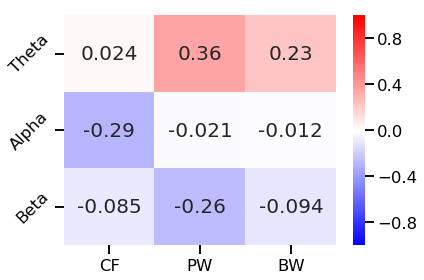

In [14]:
# Plot the correlation matrix of the ratio measure and spectral features
plot_param_ratio_corr(tbr_per, save_fig=SAVE_FIG, file_name="Global_TBR_corrs")
plot_param_ratio_corr_exp(tbr_ap, show=SHOW_EXP, save_fig=SAVE_FIG, file_name="Global_TBR_corrs")

### Channel Sub-Selections

The next set of cells calculates the same measures on channel sub-selections.

By default, these plots are not displayed, but are availalbe in `figures`.

In [15]:
# Frontal Channels
tbr_per_fr, tbr_ap_fr = param_ratio_corr(df, "TBR", ch_inds_frontal, func=nan_corr_spearman)
print_aperiodic_correlation("TBR", tbr_ap_fr, show=SHOW_SUB)
plot_param_ratio_corr(tbr_per_fr, show=SHOW_SUB, save_fig=SAVE_FIG, file_name="Frontal_TBR_corrs")
plot_param_ratio_corr_exp(tbr_ap_fr, show=False, save_fig=SAVE_FIG, file_name="Frontal_TBR_corrs")

In [16]:
# Central channels
tbr_per_ce, tbr_ap_ce = param_ratio_corr(df, "TBR", ch_inds_central, func=nan_corr_spearman)
print_aperiodic_correlation("TBR", tbr_ap_ce, show=SHOW_SUB)
plot_param_ratio_corr(tbr_per_ce, show=SHOW_SUB, save_fig=SAVE_FIG, file_name="Central_TBR_corrs")
plot_param_ratio_corr_exp(tbr_ap_ce, show=False, save_fig=SAVE_FIG, file_name="Central_TBR_corrs")

In [17]:
# Parietal channels
tbr_per_pa, tbr_ap_pa = param_ratio_corr(df, "TBR", ch_inds_parietal, func=nan_corr_spearman)
print_aperiodic_correlation("TBR", tbr_ap_pa, show=SHOW_SUB)
plot_param_ratio_corr(tbr_per_pa, show=SHOW_SUB, save_fig=SAVE_FIG, file_name="Parietal_TBR_corrs")
plot_param_ratio_corr_exp(tbr_ap_pa, show=False, save_fig=SAVE_FIG, file_name="Parietal_TBR_corrs")

## TAR: Theta Alpha Ratio

Compare the theta-alpha ratio to spectral parameters.

### Global

Calculate the relationship between ratio measure and spectral features, across all channels.

In [18]:
tar_per, tar_ap = param_ratio_corr(df, "TAR", all_chans, func=nan_corr_spearman)
print_aperiodic_correlation("TAR", tar_ap)

The corr of TAR to Exp is 0.19
The corr of TAR to Off is 0.17
The corr of TAR to Age is -0.33


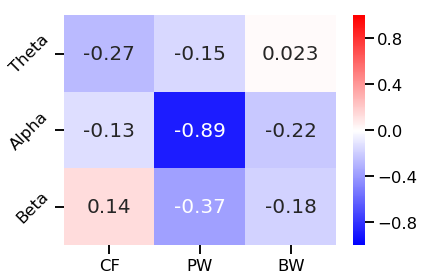

In [19]:
plot_param_ratio_corr(tar_per, save_fig=SAVE_FIG, file_name="Global_TAR_corrs")
plot_param_ratio_corr_exp(tar_ap, show=SHOW_EXP, save_fig=SAVE_FIG, file_name="Global_TAR_corrs")

### Channel Sub-Selections

The next set of cells calculates the same measures on channel sub-selections.

By default, these plots are not displayed, but are availalbe in `figures`.

In [20]:
# Frontal Channels
tar_per_fr, tar_ap_fr = param_ratio_corr(df, "TAR", ch_inds_frontal, func=nan_corr_spearman)
print_aperiodic_correlation("TAR", tar_ap_fr, show=SHOW_SUB)
plot_param_ratio_corr(tar_per_fr, show=SHOW_SUB, save_fig=SAVE_FIG, file_name="Frontal_TAR_corrs")
plot_param_ratio_corr_exp(tar_ap_fr, show=False, save_fig=SAVE_FIG, file_name="Frontal_TAR_corrs")

In [21]:
# Central Channels
tar_per_ce, tar_ap_ce = param_ratio_corr(df, "TAR", ch_inds_central, func=nan_corr_spearman)
print_aperiodic_correlation("TAR", tar_ap_ce, show=SHOW_SUB)
plot_param_ratio_corr(tar_per_ce, show=SHOW_SUB, save_fig=SAVE_FIG, file_name="Central_TAR_corrs")
plot_param_ratio_corr_exp(tar_ap_ce, show=False, save_fig=SAVE_FIG, file_name="Central_TAR_corrs")

In [22]:
# Parietal Channels
tar_per_pa, tar_ap_pa = param_ratio_corr(df, "TAR", ch_inds_parietal, func=nan_corr_spearman)
print_aperiodic_correlation("TAR", tar_ap_pa, show=SHOW_SUB)
plot_param_ratio_corr(tar_per_pa, show=SHOW_SUB, save_fig=SAVE_FIG, file_name="Parietal_TAR_corrs")
plot_param_ratio_corr_exp(tar_ap_pa, show=False, save_fig=SAVE_FIG, file_name="Parietal_TAR_corrs")

## Alpha Beta Ratio (ABR)

Compare the theta-alpha ratio to spectral parameters.

### Global

Calculate the relationship between ratio measure and spectral features, across all channels.

In [23]:
abr_per, abr_ap = param_ratio_corr(df, "ABR", all_chans, func=nan_corr_spearman)
print_aperiodic_correlation("ABR", abr_ap)

The corr of ABR to Exp is 0.33
The corr of ABR to Off is 0.31
The corr of ABR to Age is -0.09


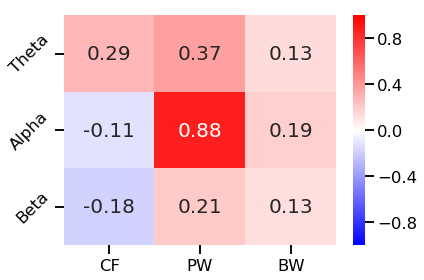

In [24]:
plot_param_ratio_corr(abr_per, save_fig=SAVE_FIG, file_name="Global_ABR_corrs")
plot_param_ratio_corr_exp(abr_ap, show=SHOW_EXP, save_fig=SAVE_FIG, file_name="Global_ABR_corrs")

### Channel Sub-Selections

The next set of cells calculates the same measures on channel sub-selections.

By default, these plots are not displayed, but are availalbe in `figures`.

In [25]:
# Frontal Channels
abr_per_fr, abr_ap_fr = param_ratio_corr(df, "ABR", ch_inds_frontal, func=nan_corr_spearman)
print_aperiodic_correlation("ABR", abr_ap_fr, show=SHOW_SUB)
plot_param_ratio_corr(abr_per_fr, show=SHOW_SUB, save_fig=SAVE_FIG, file_name="Frontal_ABR_corrs")
plot_param_ratio_corr_exp(abr_ap_fr, show=False, save_fig=SAVE_FIG, file_name="Frontal_ABR_corrs")

In [26]:
# Central Channels
abr_per_ce, abr_ap_ce = param_ratio_corr(df, "ABR", ch_inds_central, func=nan_corr_spearman)
print_aperiodic_correlation("ABR", abr_ap_ce, show=SHOW_SUB)
plot_param_ratio_corr(abr_per_ce, show=SHOW_SUB, save_fig=SAVE_FIG, file_name="Central_ABR_corrs")
plot_param_ratio_corr_exp(abr_ap_ce, show=False, save_fig=SAVE_FIG, file_name="Central_ABR_corrs")

In [27]:
# Parietal Channels
abr_per_pa, abr_ap_pa = param_ratio_corr(df, "ABR", ch_inds_parietal, func=nan_corr_spearman)
print_aperiodic_correlation("ABR", abr_ap_pa, show=SHOW_SUB)
plot_param_ratio_corr(abr_per_pa, show=SHOW_SUB, save_fig=SAVE_FIG, file_name="Parietal_ABR_corrs")
plot_param_ratio_corr_exp(abr_ap_pa, show=False, save_fig=SAVE_FIG, file_name="Parietal_ABR_corrs")